# Autoencodeur – pipeline clean (Keras/TensorFlow)
Ce notebook est une version **Keras** du pipeline autoencodeur, organisée comme un *mini-article* :

1. **Données & alignement** (expression ↔ clinique)  
2. **Construction de la cible** (Yes/No → 1/0) et séparation *labellisés* / *non labellisés*  
3. **Split patient-level** (stratifié) et **prétraitements sans fuite**  
4. **Autoencodeur (Keras)** + early stopping  
5. **Latent space (Z)** : extraction + visualisations 2D/3D  
6. **Évaluation downstream** : kNN sur **X_in** vs **Z** (ROC/PR + métriques)  
7. **Cas illustratif** : un patient + ses K voisins (distances + outcomes)

> ⚠️ Important : pour éviter toute fuite, les transforms (scaler/PCA) et l’autoencodeur sont **fit uniquement sur le set d’entraînement AE**.


## 0) Setup & paramètres
- Mets ici les chemins vers tes fichiers (expression + meta).
- Adapte les noms de colonnes d’ID si besoin.
- Choisis si tu veux entraîner l’autoencodeur aussi sur les patients **non labellisés** (souvent utile en semi-supervisé non paramétrique).


In [13]:

# --- Imports ---
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score, balanced_accuracy_score,
    RocCurveDisplay, PrecisionRecallDisplay
)
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import warnings
warnings.filterwarnings("ignore") 

# --- Reproductibilité ---
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# --- Répertoires ---
PROJECT_ROOT = os.getcwd()

DIRS = {
    "RAW": os.path.join(PROJECT_ROOT, "data", "raw"),
    "PROCESSED": os.path.join(PROJECT_ROOT, "data", "processed"),
    "NORM": os.path.join(PROJECT_ROOT, "data", "processed", "normalized"),
    "FIGURES": os.path.join(PROJECT_ROOT, "data", "artefacts", "autoencoder_analysis")
}

for path in DIRS.values():
    os.makedirs(path, exist_ok=True)


# --- I/O ---
# EXPR_PATH = r"PATH/TO/expression.csv"   # Non utilisé (on charge depuis DIRS)
# META_PATH = r"PATH/TO/meta.csv"         # Non utilisé (on charge depuis DIRS)

# Colonnes d'ID à adapter à ton format
# EXPR_ID_COL = "patient"                 # Non utilisé (fichiers déjà indexés)
# META_ID_COL = "patient"

TARGET_COL  = "paper_recurred_progressed"

# --- Hyperparams ---
TEST_SIZE = 0.20
LATENT_DIM = 32
BATCH_SIZE = 64
EPOCHS = 300
PATIENCE = 25

# Réduction de dimension avant AE (souvent indispensable avec 21k gènes)
# Note preprocessing : `PCA_NCOMP` ajusté à 400 (au lieu de 512) car le nombre d'échantillons en train AE (n=481) 
# impose la contrainte `n_components < min(n_samples, n_features)`.
USE_PCA = True
PCA_NCOMP = 400     

# Entraîner AE aussi sur les non-labellisés (recommandé si beaucoup de non labellisés)
INCLUDE_UNLABELED_IN_AE_TRAIN = True

# kNN downstream
K_NEIGHBORS = 10

# Dossier figures
FIGDIR = DIRS["FIGURES"]
# os.makedirs(FIGDIR, exist_ok=True)  # Déjà créé via DIRS

print("TensorFlow:", tf.__version__)


TensorFlow: 2.10.0


## 1) Chargement & alignement patient-level

**Fichiers chargés** :
- **Expression** : Données normalisées et filtrées (sortie du pipeline QC de 0B - 553 patientes × 21168 gènes)
- **Métadonnées** : Table clinique complète

**Alignement** : On ne garde que les patientes présentes à la fois dans les données d'expression ET dans les métadonnées cliniques (intersection des IDs). <Br>Patient-level: Les dataframes sont déjà indexés par patient ID au niveau du fichier.


In [3]:

# --- Chargement ---
expr = pd.read_csv(os.path.join(DIRS["NORM"], "expr_norm_filtered.csv.gz"), index_col=0, compression="gzip")
meta = pd.read_csv(os.path.join(DIRS["RAW"], "metadata_clinical_merged.csv.gz"), index_col=0, compression="gzip")

# Alignement IDs (intersection)
common_ids = expr.index.intersection(meta.index)
expr = expr.loc[common_ids].copy()
meta = meta.loc[common_ids].copy()

print("N patients alignés:", len(common_ids))
print("Expr shape (patients x features):", expr.shape)


N patients alignés: 553
Expr shape (patients x features): (553, 21168)


## 2) Construction de la cible (y) + masques
On mappe `Yes/No` → `1/0`.  
Ensuite :
- `idx_labeled` : patients avec y connu
- `idx_unlabeled` : y manquant


In [4]:

# --- y binaire propre ---
y_str = meta[TARGET_COL].astype(str).str.strip().str.lower()
y = y_str.map({"yes": 1, "no": 0})

mask_labeled = y.notna().to_numpy()
idx_labeled = np.where(mask_labeled)[0]
idx_unlabeled = np.where(~mask_labeled)[0]

print(f"Total: {len(y)}")
print(f"Labeled: {len(idx_labeled)} | Unlabeled: {len(idx_unlabeled)}")

# X complet (pour encoder tout le monde ensuite)
X_all = expr.to_numpy(dtype=np.float32)

# y pour les labellisés uniquement
y_labeled = y.iloc[idx_labeled].to_numpy(dtype=np.int32)
print("Positifs:", int(y_labeled.sum()), "/", len(y_labeled), f"({y_labeled.mean()*100:.1f}%)")


Total: 553
Labeled: 357 | Unlabeled: 196
Positifs: 72 / 357 (20.2%)


#### Vérification de la distribution de la cible

Diagnostic du déséquilibre de classes et du nombre de patientes labellisées/non-labellisées.

In [5]:
print(f"\nDISTRIBUTION DE LA CIBLE '{TARGET_COL}' :")
print(meta[TARGET_COL].value_counts(dropna=False))
print(f"\nLabeled   : {len(idx_labeled)} patientes")
print(f"Unlabeled : {len(idx_unlabeled)} patientes (NaN ou autre valeur)")


DISTRIBUTION DE LA CIBLE 'paper_recurred_progressed' :
paper_recurred_progressed
No         285
NaN        174
Yes         72
Unknown     22
Name: count, dtype: int64

Labeled   : 357 patientes
Unlabeled : 196 patientes (NaN ou autre valeur)


## 3) Split patient-level (stratifié) + sets AE/train/test
On fait le split **uniquement** sur les patients labellisés (car il faut `stratify=y`).  
Puis on définit :

- `idx_test` : labellisés test  
- `idx_train_lab` : labellisés train  
- `idx_train_ae` : set d’entraînement de l’autoencodeur (train labellisés + éventuellement non labellisés)

👉 L’AE **ne voit jamais** les patients du test, pour éviter toute fuite.


In [6]:

# Indices relatifs à la liste idx_labeled
rel_all = np.arange(len(idx_labeled))
rel_train, rel_test = train_test_split(
    rel_all, test_size=TEST_SIZE, random_state=SEED, stratify=y_labeled
)

idx_train_lab = idx_labeled[rel_train]
idx_test      = idx_labeled[rel_test]

if INCLUDE_UNLABELED_IN_AE_TRAIN:
    idx_train_ae = np.concatenate([idx_train_lab, idx_unlabeled])
else:
    idx_train_ae = idx_train_lab.copy()

print("Train labeled:", len(idx_train_lab))
print("Test labeled :", len(idx_test))
print("Train AE     :", len(idx_train_ae))

# Sanity: pas d'intersection train_ae / test
assert len(np.intersect1d(idx_train_ae, idx_test)) == 0


Train labeled: 285
Test labeled : 72
Train AE     : 481


## 4) Prétraitements sans fuite (scaler + PCA optionnel)
- **Scaler** fit sur `idx_train_ae` uniquement.
- **PCA** (si activé) fit sur `idx_train_ae` uniquement.


In [7]:

# --- scaler ---
scaler = StandardScaler(with_mean=True, with_std=True)
X_train_ae_scaled = scaler.fit_transform(X_all[idx_train_ae])

X_all_scaled = scaler.transform(X_all)  # transform sur tous, mais scaler fit sur train_ae

# --- PCA (optionnelle) ---
if USE_PCA:
    pca = PCA(n_components=PCA_NCOMP, random_state=SEED)
    X_train_ae_in = pca.fit_transform(X_train_ae_scaled)
    X_all_in      = pca.transform(X_all_scaled)
    input_dim = X_train_ae_in.shape[1]
    explained = pca.explained_variance_ratio_.sum()
    print(f"PCA: input_dim={input_dim} | variance expliquée ~ {explained:.2f}")
else:
    X_train_ae_in = X_train_ae_scaled
    X_all_in      = X_all_scaled
    input_dim = X_train_ae_in.shape[1]
    print(f"No PCA: input_dim={input_dim}")

# X_in pour train/test labellisés (downstream)
X_train_in = X_all_in[idx_train_lab]
X_test_in  = X_all_in[idx_test]
y_train    = y.iloc[idx_train_lab].to_numpy(dtype=np.int32)
y_test     = y.iloc[idx_test].to_numpy(dtype=np.int32)

print("X_train_in:", X_train_in.shape, "| X_test_in:", X_test_in.shape)


PCA: input_dim=400 | variance expliquée ~ 0.98
X_train_in: (285, 400) | X_test_in: (72, 400)


## 5) Autoencodeur (Keras)
Architecture Dense symétrique :
- Encodeur : 512 → 256 → `LATENT_DIM`
- Décodeur : 256 → 512 → reconstruction


Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 X_in (InputLayer)           [(None, 400)]             0         
                                                                 
 dense (Dense)               (None, 512)               205312    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                       

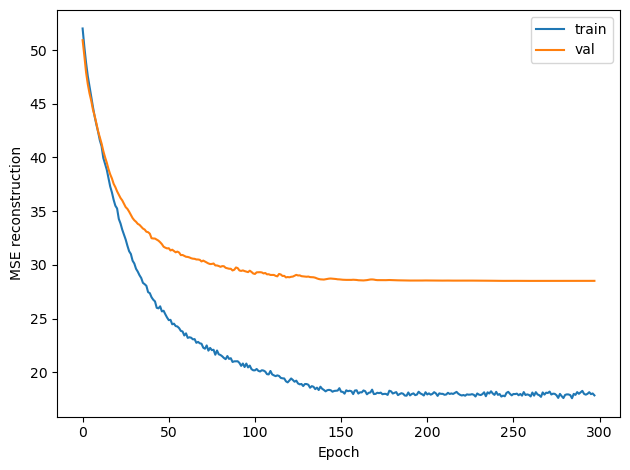

In [8]:

def build_autoencoder(input_dim: int, latent_dim: int = 32, dropout: float = 0.1):
    inp = keras.Input(shape=(input_dim,), name="X_in")

    x = layers.Dense(512)(inp)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(dropout)(x)

    x = layers.Dense(256)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(dropout)(x)

    z = layers.Dense(latent_dim, name="Z")(x)

    x = layers.Dense(256)(z)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(dropout)(x)

    x = layers.Dense(512)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(dropout)(x)

    out = layers.Dense(input_dim, name="X_recon")(x)

    auto = keras.Model(inp, out, name="autoencoder")
    encoder = keras.Model(inp, z, name="encoder")

    auto.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mse")
    return auto, encoder

autoencoder, encoder = build_autoencoder(input_dim=input_dim, latent_dim=LATENT_DIM, dropout=0.15)
autoencoder.summary()

callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=8, factor=0.5, min_lr=1e-5)
]

history = autoencoder.fit(
    X_train_ae_in, X_train_ae_in,
    validation_split=0.1,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

# --- Figure : learning curves ---
plt.figure()
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.xlabel("Epoch")
plt.ylabel("MSE reconstruction")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(FIGDIR, "Fig1_training_curve.png"), dpi=200)
plt.show()


## 6) Extraction du latent space Z + reconstruction error

Z_all: (553, 32)
Recon err: mean 14.352116584777832 std 7.151321887969971


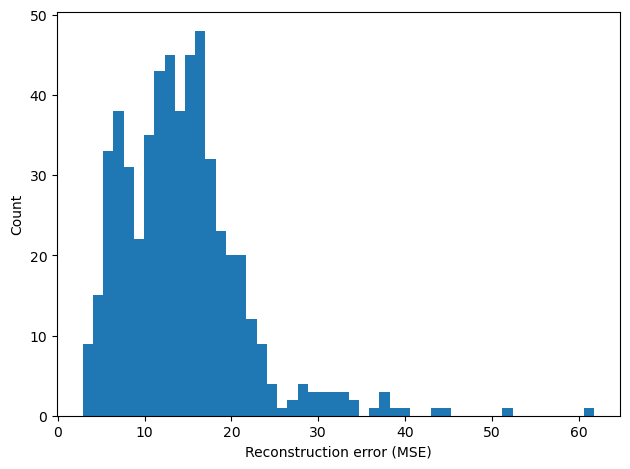

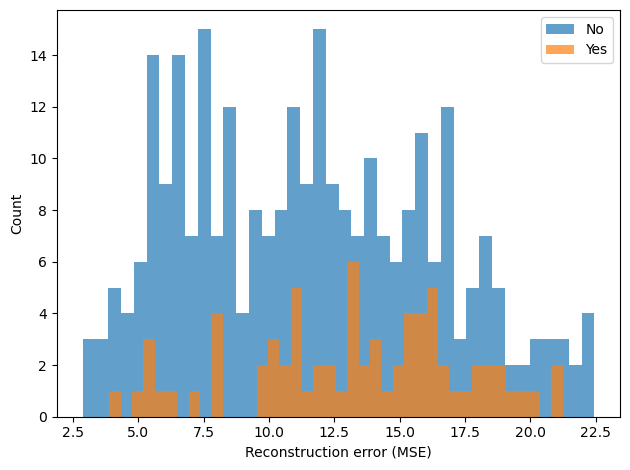

In [9]:

# --- Encodage ---
Z_all = encoder.predict(X_all_in, batch_size=512, verbose=0)

# --- Reconstruction error ---
X_recon = autoencoder.predict(X_all_in, batch_size=512, verbose=0)
recon_err = np.mean((X_all_in - X_recon)**2, axis=1)

print("Z_all:", Z_all.shape)
print("Recon err: mean", float(np.mean(recon_err)), "std", float(np.std(recon_err)))

# --- Figure : distribution recon error ---
plt.figure()
plt.hist(recon_err, bins=50)
plt.xlabel("Reconstruction error (MSE)")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig(os.path.join(FIGDIR, "Fig2_recon_error_hist.png"), dpi=200)
plt.show()

# --- Figure : recon error par label (labellisés uniquement) ---
plt.figure()
plt.hist(recon_err[idx_labeled][y_labeled==0], bins=40, alpha=0.7, label="No")
plt.hist(recon_err[idx_labeled][y_labeled==1], bins=40, alpha=0.7, label="Yes")
plt.xlabel("Reconstruction error (MSE)")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(FIGDIR, "Fig2b_recon_error_by_label.png"), dpi=200)
plt.show()


## 7) Visualisation du latent space (Z) – 2D & 3D (PCA sur Z)

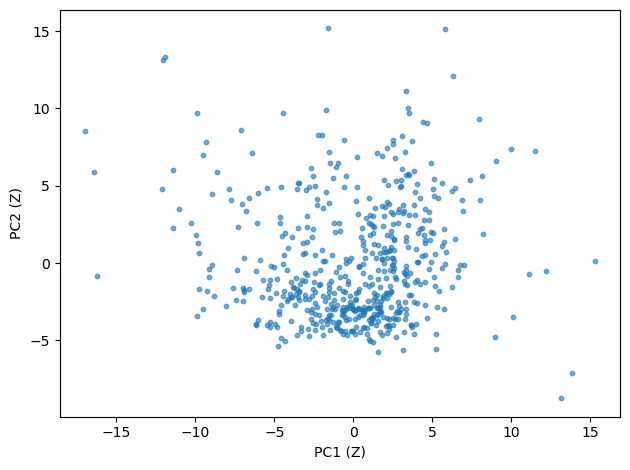

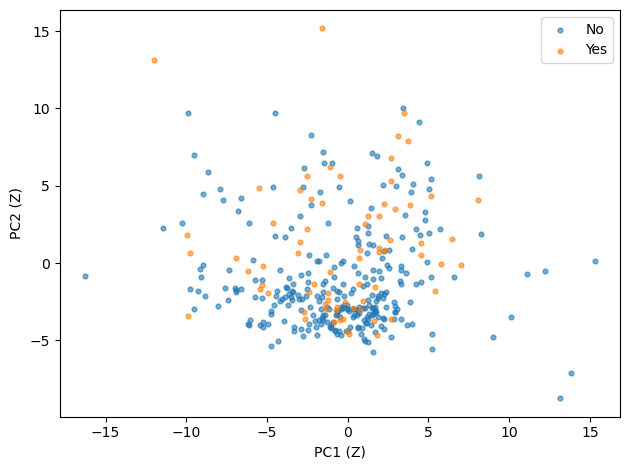

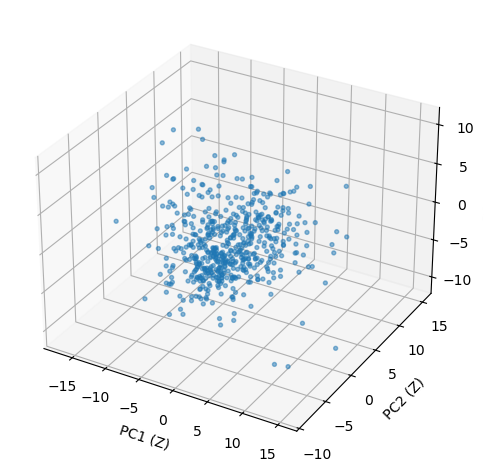

In [14]:

from sklearn.decomposition import PCA

pcaZ2 = PCA(n_components=2, random_state=SEED)
Z2 = pcaZ2.fit_transform(Z_all)

plt.figure()
plt.scatter(Z2[:,0], Z2[:,1], s=10, alpha=0.6)
plt.xlabel("PC1 (Z)")
plt.ylabel("PC2 (Z)")
plt.tight_layout()
plt.savefig(os.path.join(FIGDIR, "Fig3_Z_PCA2_all.png"), dpi=200)
plt.show()

# Coloré par label (labellisés seulement)
plt.figure()
mask0 = (y.iloc[idx_labeled].to_numpy()==0)
mask1 = (y.iloc[idx_labeled].to_numpy()==1)
plt.scatter(Z2[idx_labeled][mask0,0], Z2[idx_labeled][mask0,1], s=12, alpha=0.6, label="No")
plt.scatter(Z2[idx_labeled][mask1,0], Z2[idx_labeled][mask1,1], s=12, alpha=0.6, label="Yes")
plt.xlabel("PC1 (Z)")
plt.ylabel("PC2 (Z)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(FIGDIR, "Fig3b_Z_PCA2_labeled.png"), dpi=200)
plt.show()

# 3D
from mpl_toolkits.mplot3d import Axes3D  # noqa
pcaZ3 = PCA(n_components=3, random_state=SEED)
Z3 = pcaZ3.fit_transform(Z_all)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(Z3[:,0], Z3[:,1], Z3[:,2], s=8, alpha=0.5)
ax.set_xlabel("PC1 (Z)")
ax.set_ylabel("PC2 (Z)")
ax.set_zlabel("PC3 (Z)")
plt.tight_layout()
plt.savefig(os.path.join(FIGDIR, "Fig3c_Z_PCA3_all.png"), dpi=200)
plt.show()


## 8) Downstream : kNN sur X_in vs kNN sur Z (ROC/PR)

kNN on X_in: {'ROC_AUC': 0.41520467836257313, 'PR_AUC': 0.18583820063842216, 'F1': 0.0, 'BalAcc': 0.5}
kNN on Z   : {'ROC_AUC': 0.395906432748538, 'PR_AUC': 0.19333433352644339, 'F1': 0.0, 'BalAcc': 0.5}


<Figure size 640x480 with 0 Axes>

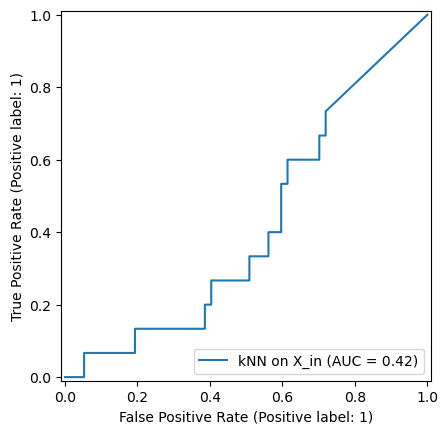

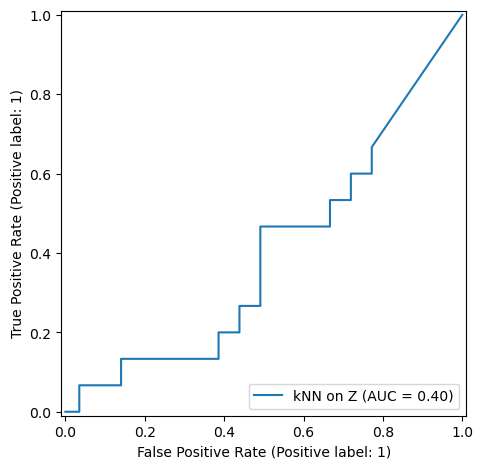

<Figure size 640x480 with 0 Axes>

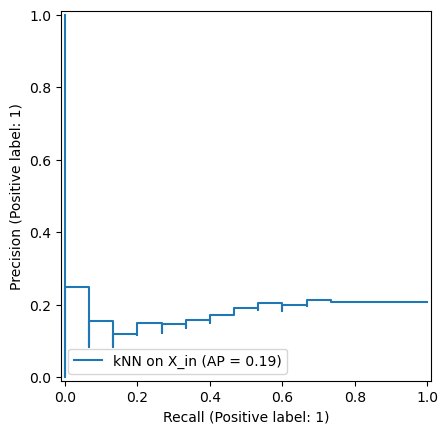

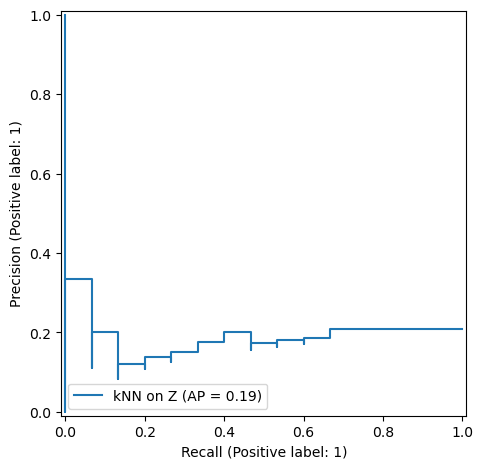

In [15]:
def eval_knn(Xtr, Xte, ytr, yte, k=10):
    clf = KNeighborsClassifier(n_neighbors=k, weights="distance")
    clf.fit(Xtr, ytr)
    proba = clf.predict_proba(Xte)[:,1]
    pred = (proba >= 0.5).astype(int)

    out = {
        "ROC_AUC": roc_auc_score(yte, proba) if len(np.unique(yte))==2 else np.nan,
        "PR_AUC": average_precision_score(yte, proba) if len(np.unique(yte))==2 else np.nan,
        "F1": f1_score(yte, pred, zero_division=0),
        "BalAcc": balanced_accuracy_score(yte, pred),
        "proba": proba,
        "pred": pred
    }
    return out

res_X = eval_knn(X_train_in, X_test_in, y_train, y_test, k=K_NEIGHBORS)

Z_train = Z_all[idx_train_lab]
Z_test  = Z_all[idx_test]
res_Z = eval_knn(Z_train, Z_test, y_train, y_test, k=K_NEIGHBORS)

print("kNN on X_in:", {k:v for k,v in res_X.items() if k not in ("proba","pred")})
print("kNN on Z   :", {k:v for k,v in res_Z.items() if k not in ("proba","pred")})

# ROC
plt.figure()
RocCurveDisplay.from_predictions(y_test, res_X["proba"], name="kNN on X_in")
RocCurveDisplay.from_predictions(y_test, res_Z["proba"], name="kNN on Z")
plt.tight_layout()
plt.savefig(os.path.join(FIGDIR, "Fig4_ROC_X_vs_Z.png"), dpi=200)
plt.show()

# PR
plt.figure()
PrecisionRecallDisplay.from_predictions(y_test, res_X["proba"], name="kNN on X_in")
PrecisionRecallDisplay.from_predictions(y_test, res_Z["proba"], name="kNN on Z")
plt.tight_layout()
plt.savefig(os.path.join(FIGDIR, "Fig4b_PR_X_vs_Z.png"), dpi=200)
plt.show()


## 9) Cas illustratif : un patient test + ses K voisins en Z

Patient index (global): 543
Predicted risk (neighbors): 0.11737552293879712
Neighbors positives: 1 / 10


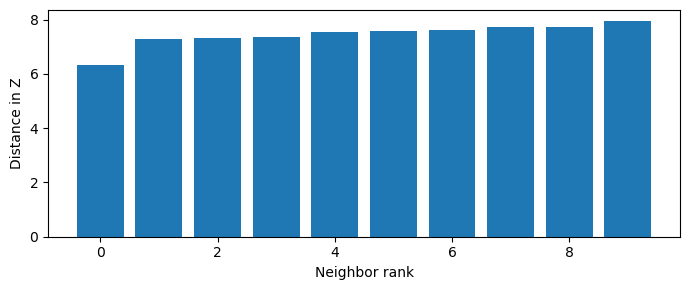

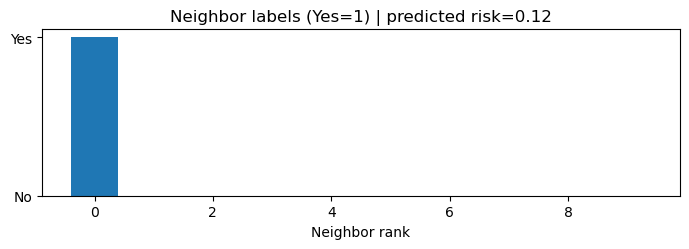

,neighbor_id,distance,y
0,TCGA-B5-A0K7-01A-11R-A104-07,6.317755,1
1,TCGA-A5-A0GU-01A-11R-A16W-07,7.302484,0
2,TCGA-BG-A0MS-01A-11R-A104-07,7.309755,0
3,TCGA-D1-A16R-01A-11R-A12I-07,7.359785,0
4,TCGA-B5-A11Z-01A-11R-A10J-07,7.557131,0
5,TCGA-D1-A160-01A-11R-A118-07,7.579307,0
6,TCGA-BG-A0M3-01A-11R-A104-07,7.602805,0
7,TCGA-D1-A161-01A-11R-A118-07,7.709821,0
8,TCGA-D1-A162-01A-11R-A118-07,7.726977,0
9,TCGA-BG-A0MU-01A-11R-A104-07,7.954761,0


In [16]:

# Choisir un patient du test (ex: le premier)
i_test = 0
idx_patient = idx_test[i_test]

# Voisins cherchés dans le TRAIN labellisé (sinon fuite)
nbrs = NearestNeighbors(n_neighbors=K_NEIGHBORS, metric="euclidean")
nbrs.fit(Z_train)

dist, ind = nbrs.kneighbors(Z_all[idx_patient].reshape(1,-1))
dist = dist.flatten()
ind = ind.flatten()

neighbor_idx_global = idx_train_lab[ind]
neighbor_y = y.iloc[neighbor_idx_global].to_numpy(dtype=int)

# Prédiction simple : moyenne pondérée (inverse distance)
w = 1.0 / (dist + 1e-6)
pred_risk = float(np.sum(w * neighbor_y) / np.sum(w))

print("Patient index (global):", idx_patient)
print("Predicted risk (neighbors):", pred_risk)
print("Neighbors positives:", int(neighbor_y.sum()), "/", len(neighbor_y))

plt.figure(figsize=(7,3))
plt.bar(np.arange(len(dist)), dist)
plt.xlabel("Neighbor rank")
plt.ylabel("Distance in Z")
plt.tight_layout()
plt.savefig(os.path.join(FIGDIR, "Fig5_patient_neighbor_distances.png"), dpi=200)
plt.show()

plt.figure(figsize=(7,2.6))
plt.bar(np.arange(len(neighbor_y)), neighbor_y)
plt.yticks([0,1], ["No","Yes"])
plt.xlabel("Neighbor rank")
plt.title(f"Neighbor labels (Yes=1) | predicted risk={pred_risk:.2f}")
plt.tight_layout()
plt.savefig(os.path.join(FIGDIR, "Fig5b_patient_neighbor_labels.png"), dpi=200)
plt.show()

# Afficher IDs si dispo
patient_id = expr.index[idx_patient]
neighbor_ids = expr.index[neighbor_idx_global]
display(pd.DataFrame({"neighbor_id": neighbor_ids, "distance": dist, "y": neighbor_y}))


## 10) Export (optionnel) : Z + recon_err

In [17]:

out = pd.DataFrame(Z_all, index=expr.index, columns=[f"Z{i+1}" for i in range(Z_all.shape[1])])
out["recon_err"] = recon_err
out["y"] = y  # NaN pour non labellisés

OUT_CSV = "latent_Z_keras.csv"
out.to_csv(OUT_CSV)
print("Saved:", OUT_CSV)


Saved: latent_Z_keras.csv
